<a href="https://colab.research.google.com/github/Aditipatel0811/NN-DL/blob/main/AditiPatel_204_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **Loading the dataset**

In [17]:
(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# **Preprocess the data**

In [18]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

train_data = train_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

**Convert dataset to numpy arrays**

In [19]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_data)
X_test, y_test = dataset_to_numpy(test_data)

Reshape the images

In [20]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# **Radial Basis Function (RBF) Network**

In [21]:
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, centers):
        super(RBFLayer, self).__init__()
        self.num_outputs = num_outputs
        self.centers = centers

    def build(self, input_shape):
        self.betas = self.add_weight(name='betas', shape=(self.num_outputs,),
                                     initializer='ones', trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        C = tf.expand_dims(self.centers, axis=0)
        H = tf.transpose(C - tf.expand_dims(inputs, axis=1), perm=[0, 2, 1])
        return tf.exp(-self.betas * tf.reduce_sum(H**2, axis=1))

#**Training**

** Using K-means to determine RBF centers**

In [22]:
num_rbf = 50
kmeans = KMeans(n_clusters=num_rbf, n_init=10)
kmeans.fit(X_train)
rbf_centers = kmeans.cluster_centers_

**Building the model**

In [23]:
model = tf.keras.Sequential([
    RBFLayer(num_rbf, rbf_centers),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

In [24]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.0996 - loss: 2.3037 - val_accuracy: 0.0972 - val_loss: 2.3052
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1235 - loss: 2.2724 - val_accuracy: 0.1947 - val_loss: 2.1435
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.1844 - loss: 2.1661 - val_accuracy: 0.1976 - val_loss: 2.1291
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.1869 - loss: 2.1499 - val_accuracy: 0.1967 - val_loss: 2.1213
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.1905 - loss: 2.1466 - val_accuracy: 0.1725 - val_loss: 2.1406
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.1886 - loss: 2.1463 - val_accuracy: 0.2029 - val_loss: 2.1192
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.1860 - loss: 2.1484 - val_accuracy: 0.2020 - val_loss: 2.1131
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1892 -

# **Evaluation**

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.1594


In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_test, y_pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Visualizing the Confusion Matrix

Text(95.72222222222221, 0.5, 'True')

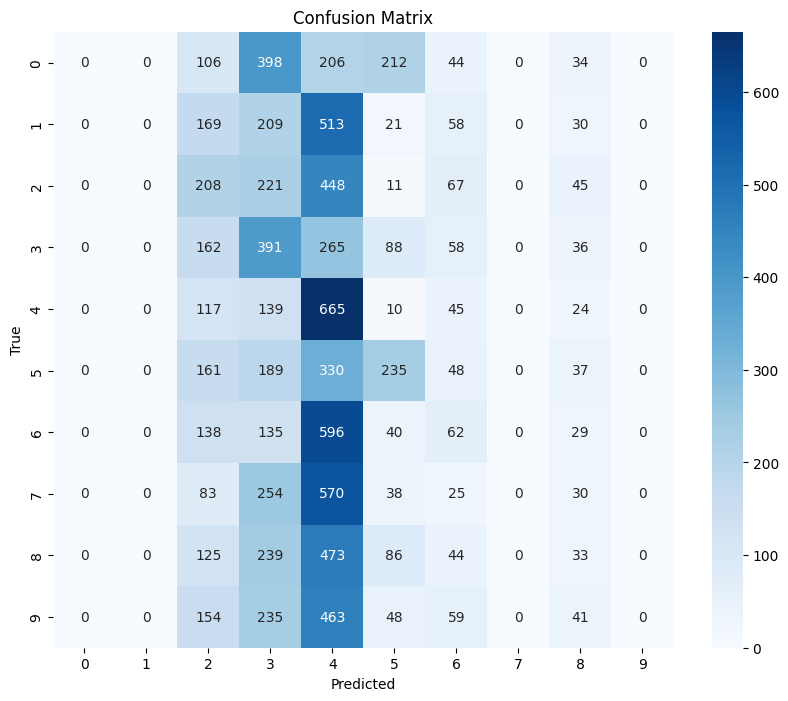

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

Visualizing the training history

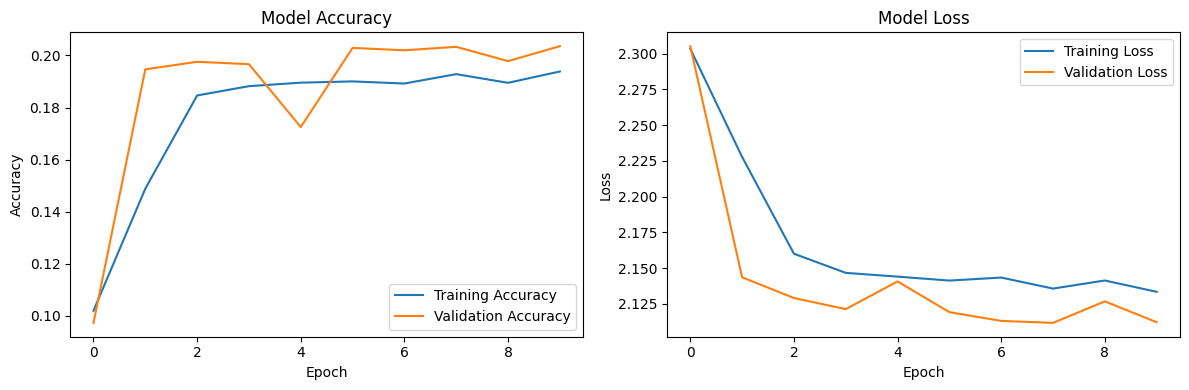

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Analysis**

In [29]:
print("Analysis:")
print("Strengths of RBF Network:")
print("1. Can model complex non-linear decision boundaries")
print("2. Faster training compared to some other neural network architectures")
print("3. Good at handling localized features in the input space")

print("\nLimitations of RBF Network:")
print("1. Performance heavily depends on the choice of centers")
print("2. May require a large number of RBF units for complex problems")
print("3. Can be sensitive to the scale of the input features")

print("\nEffect of number of RBF units:")
print("Increasing the number of RBF units can improve the model's ability to capture complex patterns,")
print("but it also increases computational cost and may lead to overfitting if too many units are used.")
print("Finding the optimal number often requires experimentation and cross-validation.")

Analysis:
Strengths of RBF Network:
1. Can model complex non-linear decision boundaries
2. Faster training compared to some other neural network architectures
3. Good at handling localized features in the input space

Limitations of RBF Network:
1. Performance heavily depends on the choice of centers
2. May require a large number of RBF units for complex problems
3. Can be sensitive to the scale of the input features

Effect of number of RBF units:
Increasing the number of RBF units can improve the model's ability to capture complex patterns,
but it also increases computational cost and may lead to overfitting if too many units are used.
Finding the optimal number often requires experimentation and cross-validation.
